In [92]:
import pandas as pd
import numpy as np

import ydata_profiling as pp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.pipeline import Pipeline

import os, pickle
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [73]:
df = pd.read_excel('data/customer_categorization.xlsx', sheet_name='Online Retail', parse_dates=True)

In [74]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [75]:
df.shape

(541909, 8)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [77]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [78]:
pp.ProfileReport(df, minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Grouping by a customer

Creating a dataset which can describe Revenue, Frequency and Recency as a key definers for a customer segmentation

In [79]:
df[df.CustomerID.isna()].shape[0]/df.shape[0]

0.249266943342886

25% of the data may be dropped as it has no relationship to any customer

In [80]:
df = df[df.CustomerID.notna()]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [81]:
df['SalesAmount'] = df.Quantity*df.UnitPrice

In [82]:
import datetime as dt

df['DaysAgo'] = (dt.datetime.now() - df['InvoiceDate']).dt.days

In [83]:
c_df = pd.DataFrame(df.groupby('CustomerID').agg({
    'SalesAmount' : 'sum',
    'InvoiceNo' : 'size',
    'DaysAgo' : 'min'
})).reset_index().rename(columns = {'Sales Amount':'Sales Amount', 'InvoiceNo':'Frequency', 'DaysAgo':'Recency'})

In [84]:
display(c_df.head())
display(c_df.info())

,CustomerID,SalesAmount,Frequency,Recency
0,12346.0,0.00,2,4632
1,12347.0,4310.00,182,4309
2,12348.0,1797.24,31,4382
3,12349.0,1757.55,73,4325
4,12350.0,334.40,17,4617


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CustomerID   4372 non-null   float64
 1   SalesAmount  4372 non-null   float64
 2   Frequency    4372 non-null   int64  
 3   Recency      4372 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 136.8 KB


None

In [85]:
pp.ProfileReport(c_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Features correlation')

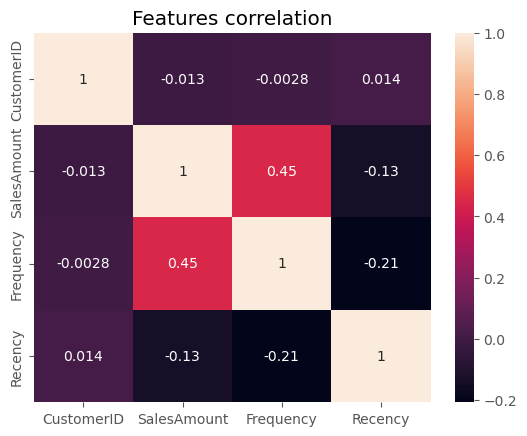

In [86]:
sns.heatmap(c_df.corr(), annot=True)
plt.title('Features correlation')

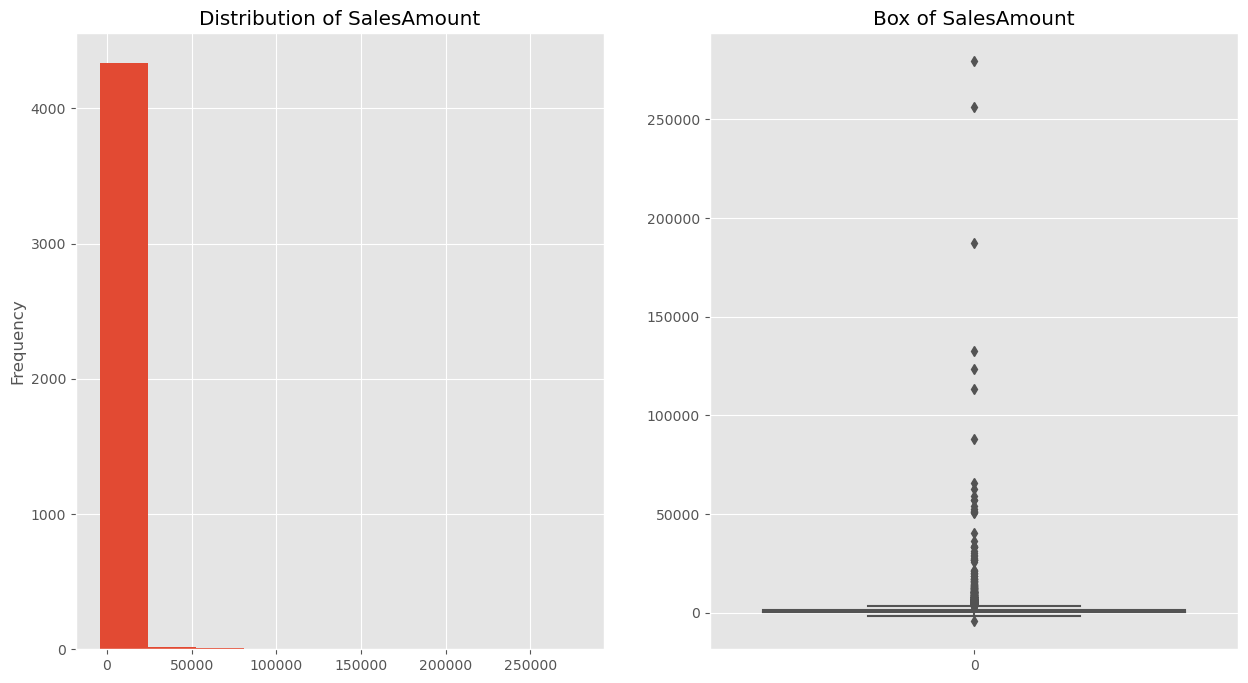

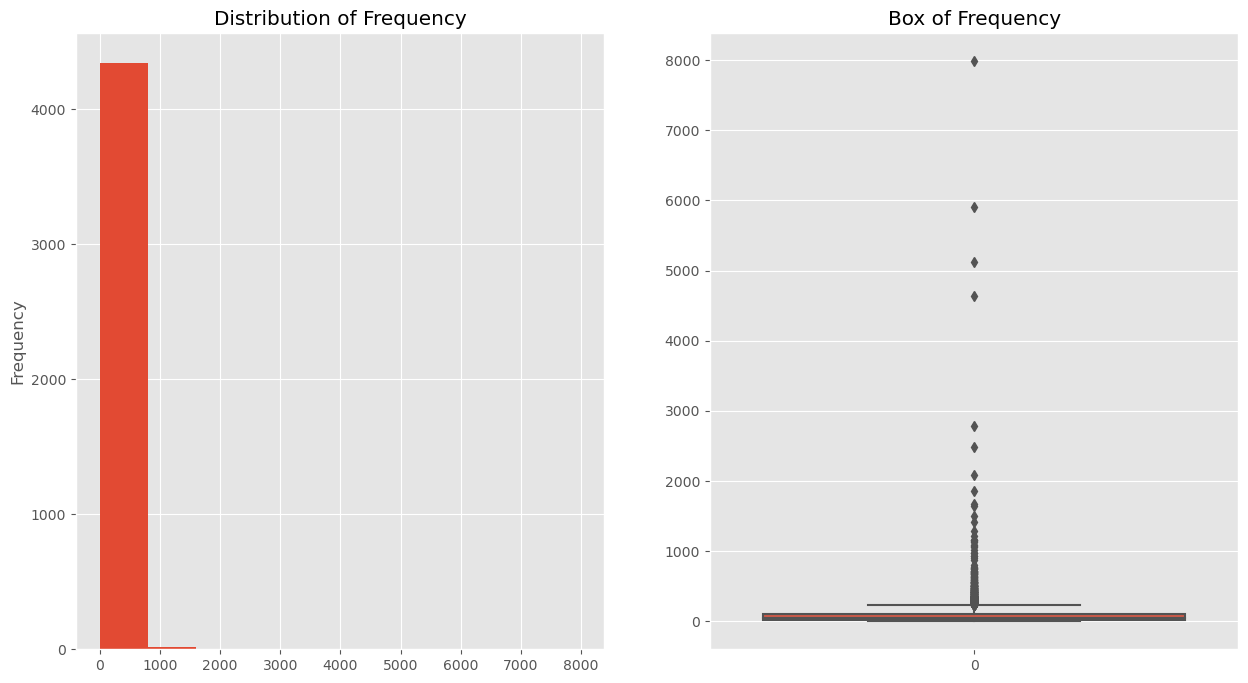

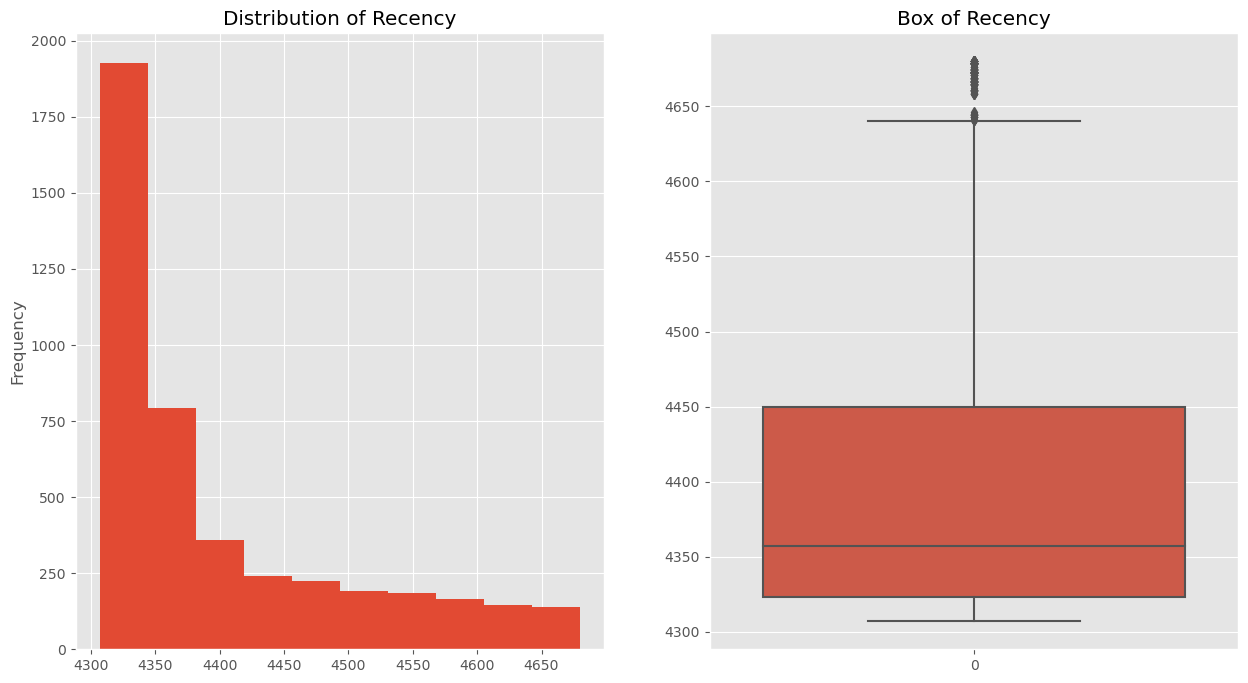

In [87]:
feature_cols = ['SalesAmount', 'Frequency', 'Recency']

for col in feature_cols:
    fig, axes = plt.subplots(1,2, figsize = (15,8))
    c_df[col].plot(kind='hist', ax=axes[0])
    axes[0].set_title('Distribution of {}'.format(col))
    sns.boxplot(c_df[col], ax=axes[1])
    axes[1].set_title('Box of {}'.format(col))
    plt.show()


There are distinctly visible outliers especially in Sales Amount and Frequency.

We can equalize it for the segmentation performance and reduce potential noice/skew

The range of 5% - 95% quantiles

In [88]:
# defining outliers equalizer function

def outliers_equalizer(df, feature_cols):
    
    for col in feature_cols:
        q1 = df[col].quantile(0.05)
        q3 = df[col].quantile(0.95)
        df[col] = np.clip(df[col],q1, q3)
    
    return df

In [90]:
c_df = outliers_equalizer(c_df, feature_cols)

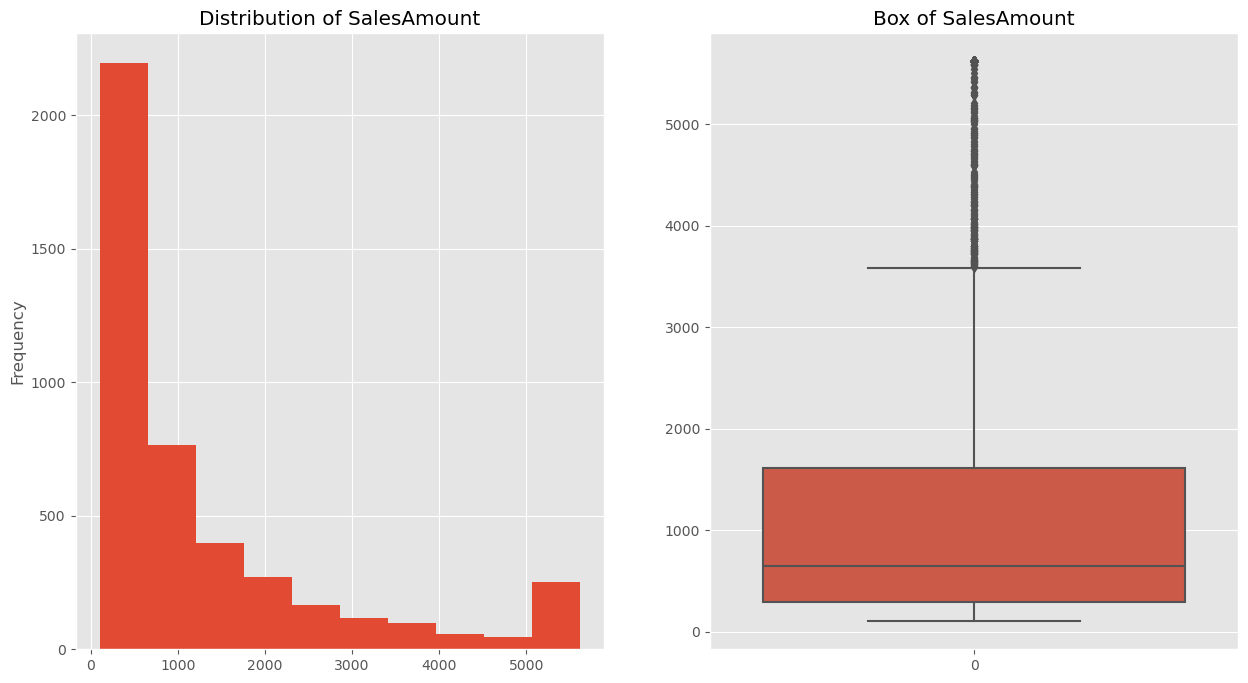

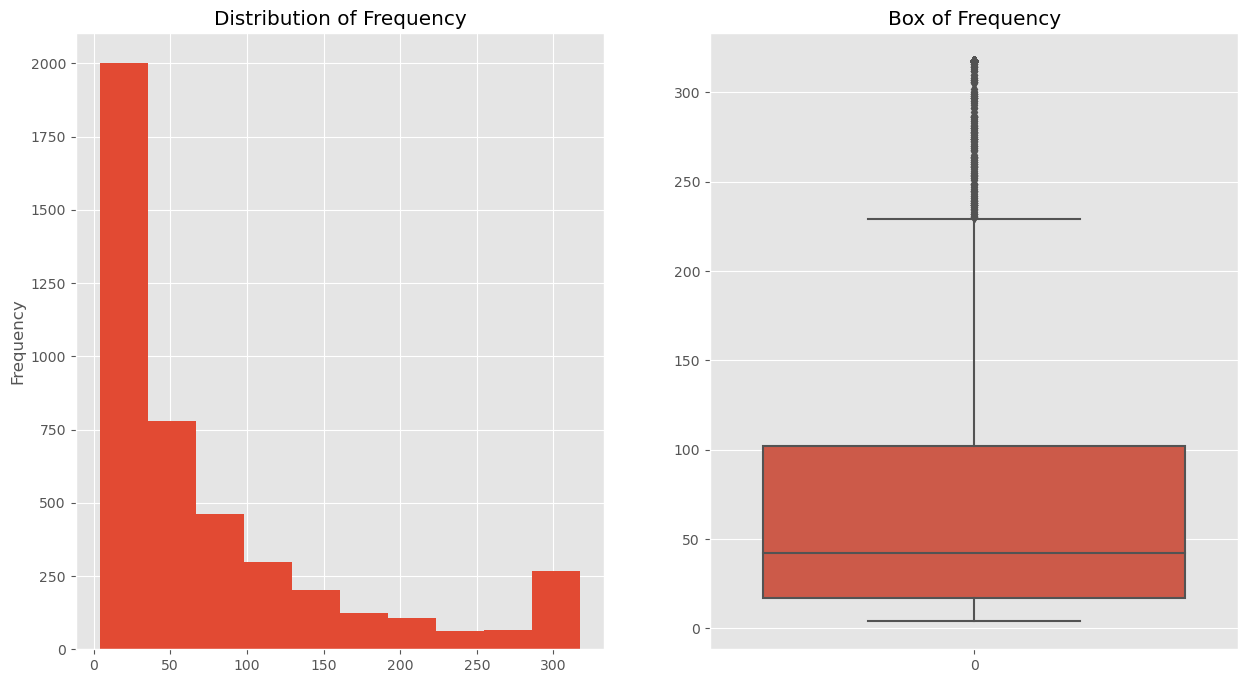

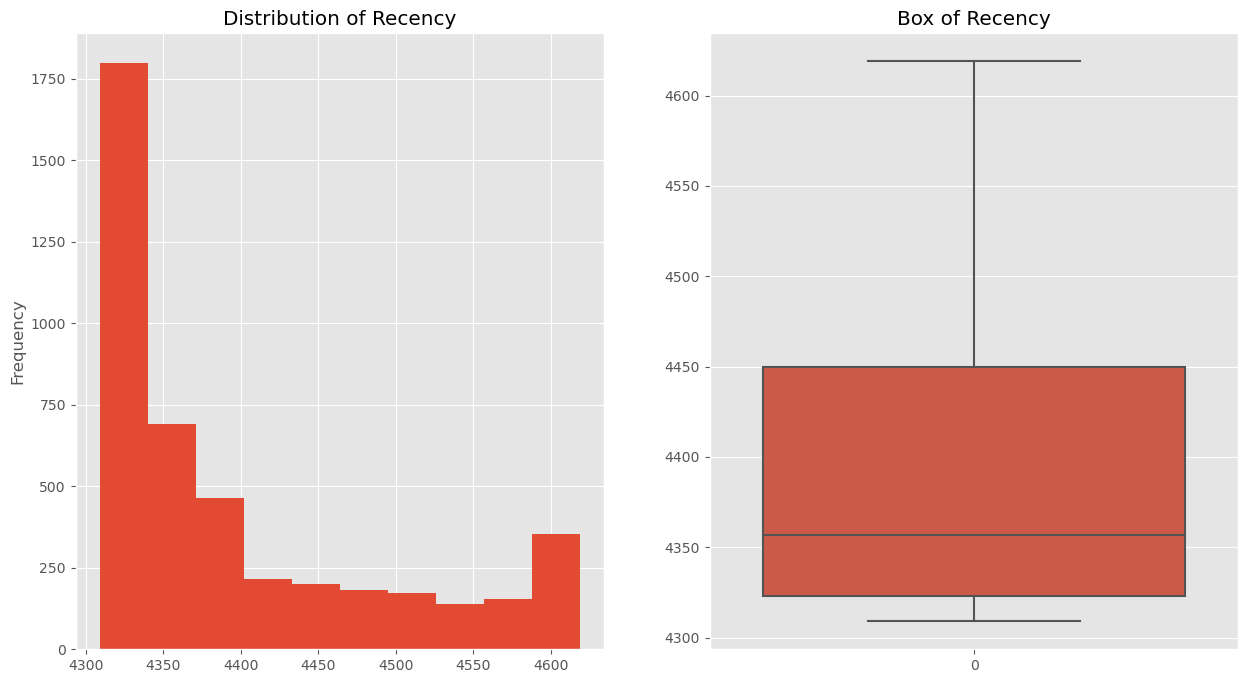

In [91]:
for col in feature_cols:
    fig, axes = plt.subplots(1,2, figsize = (15,8))
    c_df[col].plot(kind='hist', ax=axes[0])
    axes[0].set_title('Distribution of {}'.format(col))
    sns.boxplot(c_df[col], ax=axes[1])
    axes[1].set_title('Box of {}'.format(col))
    plt.show()

# Feature Engineering

In [100]:
#Scaling a dataset

X = c_df.drop(columns='CustomerID')

scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns= X[1:].columns)



In [104]:
X_scaled.shape

(4372, 3)

# Model preparation